<a href="https://colab.research.google.com/github/faizankshaikh/HomMul/blob/main/experiments/trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install -q black gymnasium pettingzoo tianshou
# !git clone https://github.com/faizankshaikh/HomMul.git

In [2]:
%cd HomMul/

/content/HomMul


In [3]:
%load_ext tensorboard

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hommul.envs.hommul_v0 import HomMul

from torch.optim import Adam

from tianshou.data import Batch
from tianshou.utils.net.common import Net
from tianshou.utils import TensorboardLogger
from tianshou.trainer import offpolicy_trainer
from tianshou.data import Collector, VectorReplayBuffer
from tianshou.env import DummyVectorEnv, PettingZooEnv
from tianshou.policy import BasePolicy, DQNPolicy, MultiAgentPolicyManager

from pettingzoo.utils import parallel_to_aec

from torch.utils.tensorboard import SummaryWriter

In [4]:
env = HomMul()
original_env = HomMul(render_mode="human")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# example of gameplay
episodes = 1

for episode in range(episodes):
    print(f"Episode #{episode+1}")
    print("=" * 10)
    obs = original_env.reset()
    print()

    while original_env.agents:
        acts = {
            "player1": np.random.choice([0, 1]),
            "player2": np.random.choice([0, 1])
        }
        print(f"--Action taken by player 1: {original_env.action_dict[acts['player1']]}")
        print(f"--Action taken by player 2: {original_env.action_dict[acts['player2']]}")
        print()

        obs, rews, terms, truncs, infos = original_env.step(acts)
        print()

Episode #1
--Days left: 1
--Current life of agent 1: 1
--Current life of agent 2: 3
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2

--Action taken by player 1: wait
--Action taken by player 2: wait

--Days left: 0
--Current life of agent 1: 0
--Current life of agent 2: 2
--Probability of payoff for agent 1: 0.2
--Probability of payoff for agent 2: 0.2
--Previous action of agent 1: wait
--Previous action of agent 2: wait



death rate of player2: 0.345
ratio of death rate of player2 with respect to player1: 0.891


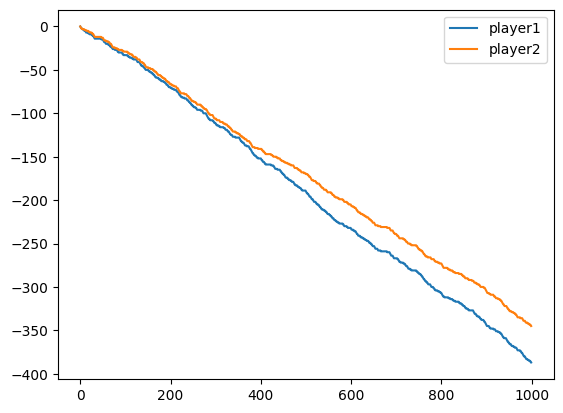

In [6]:
# both always play
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.420
ratio of death rate of player2 with respect to player1: 0.674


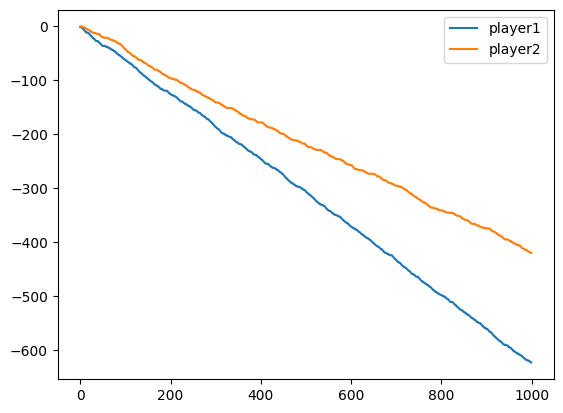

In [7]:
# both always wait
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.561
ratio of death rate of player2 with respect to player1: 0.858


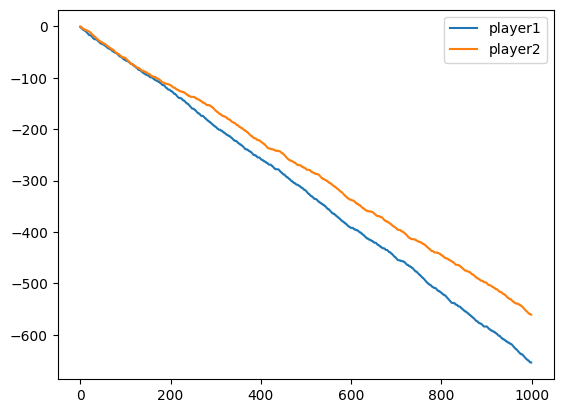

In [8]:
# player1 waits, player2 plays
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.442
ratio of death rate of player2 with respect to player1: 0.682


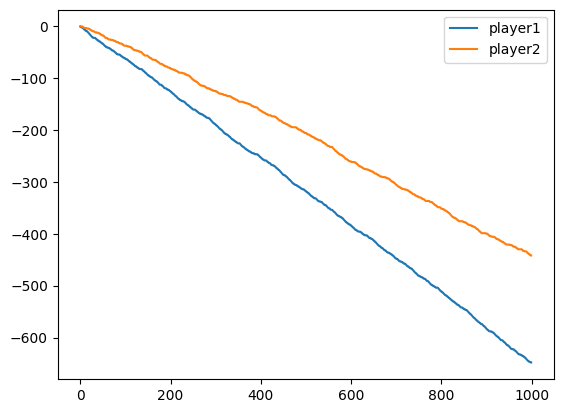

In [9]:
# player1 plays, player2 waits
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.353
ratio of death rate of player2 with respect to player1: 0.740


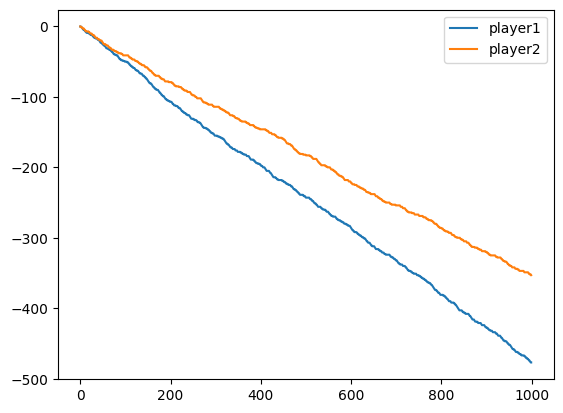

In [10]:
# Always plays vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.517
ratio of death rate of player2 with respect to player1: 0.779


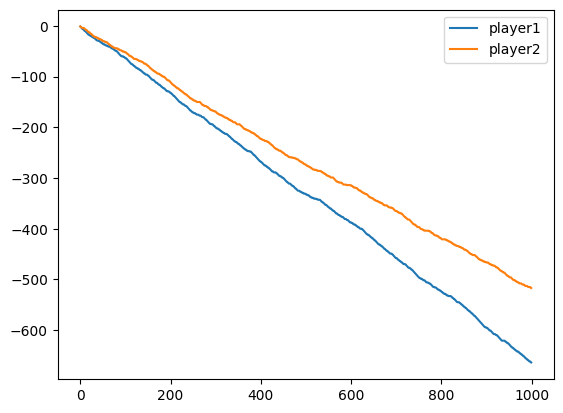

In [11]:
# Always waits vs random agent
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": np.random.choice([0, 1])
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.204
ratio of death rate of player2 with respect to player1: 0.364


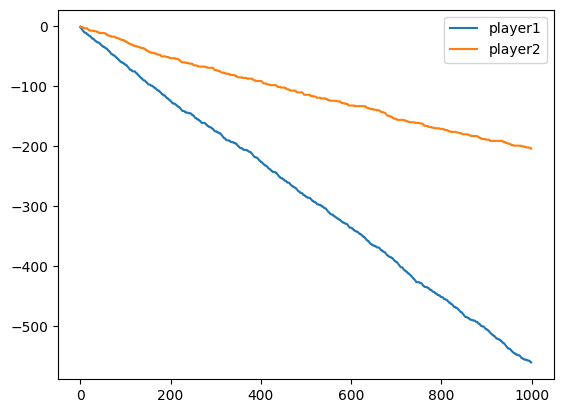

In [12]:
# Always plays vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 1,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

death rate of player2: 0.288
ratio of death rate of player2 with respect to player1: 0.455


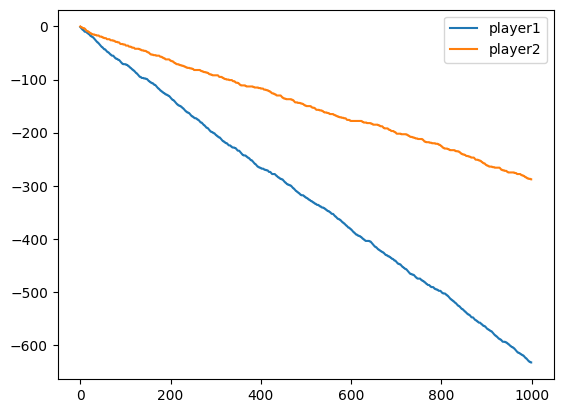

In [13]:
# Always waits vs hail mary
episodes = 1000

episode_rews = []

for _ in range(episodes):

    obs = env.reset()
    while env.agents:
        acts = {
            "player1": 0,
            "player2": 1 if obs["player2"]["observation"][0, 2] <= 1 else 0
        }

        obs, rews, terms, truncs, infos = env.step(acts)
        # print(obs, rews)

    episode_rews.append([rews['player1'], rews['player2']])

arr = np.array(episode_rews)
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [14]:
## agent that always plays
class AlwaysPlay(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)
    
    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 1] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that always waits
class AlwaysWait(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## agent that waits for low health to play
class HailMary(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        obs = batch.obs.obs

        for i in range(mask.shape[0]):
            if obs[i, :, 1] <= 1:
                logits[i, 1] = 1
            else:
                logits[i, 0] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

## random agent
class RandomAgent(BasePolicy):
    def __init__(self, **kwargs):
        self.nolearn = True
        super().__init__(**kwargs)

    def forward(self, batch, state = None):
        mask = batch.obs.mask
        logits = np.zeros(mask.shape)
        logits[:, np.random.choice([0, 1])] = 1
        logits[~mask] = -np.inf
        return Batch(act=logits.argmax(axis=-1))

    def learn(self, batch):
        return {}

In [15]:
# Step 2: Wrap the environment for Tianshou interfacing
def _get_env():
    env = HomMul()
    vec_env = parallel_to_aec(env)
    return PettingZooEnv(vec_env)

# seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

env = HomMul()
agents =  env.agents[:]

# Step 3: Define policies for each agent
## learning agent
def _get_agent(pretrained=False):
    vec_env = _get_env()
    net = Net(
        state_shape=vec_env.observation_space.shape,
        action_shape=vec_env.action_space.n,
        hidden_sizes=[128, 128],
        device="cuda",
    ).to("cuda")
    optim = Adam(net.parameters(), lr=1e-4)
    model = DQNPolicy(
        model=net,
        optim=optim,
        discount_factor=0.9,
        estimation_step=3,
        target_update_freq=50,
    )

    # if pretrained:
    #     model_save_path = os.path.join("models", "vs_hail_mary.pth")
    #     model.load_state_dict(torch.load(model_save_path))
    return model

agent_learn1 = _get_agent()
agent_learn2 = _get_agent()

policy = MultiAgentPolicyManager([AlwaysPlay(), agent_learn2],  _get_env())

train_envs = DummyVectorEnv([_get_env for _ in range(5)])
test_envs = DummyVectorEnv([_get_env for _ in range(2)])
train_envs.seed(seed)
test_envs.seed(seed)

# Step 4: Collector setup
train_collector = Collector(
    policy,
    train_envs,
    VectorReplayBuffer(20_000, len(train_envs)),
    exploration_noise=True,
)
test_collector = Collector(policy, test_envs, exploration_noise=True)

train_collector.collect(n_step=50)

def save_best_fn(policy):
    model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
    model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
    os.makedirs(os.path.join("log", "hommul", "dqn"), exist_ok=True)
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        torch.save(policy.policies[agents[0]].state_dict(), model_save_path1)
    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        torch.save(policy.policies[agents[1]].state_dict(), model_save_path2)

def stop_fn(mean_rewards):
    return mean_rewards >= 10

def train_fn(epoch, env_step):
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.1)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.1)

def test_fn(epoch, env_step):
    if not hasattr(policy.policies[agents[0]], 'nolearn'):
        policy.policies[agents[0]].set_eps(0.05)

    if not hasattr(policy.policies[agents[1]], 'nolearn'):
        policy.policies[agents[1]].set_eps(0.05)

def reward_metric(rews):
    return rews[:, 1]

In [16]:
# clear logs and setup TBoard
!rm -rf /content/HomMul/log

log_path = os.path.join("log", "hommul", "dqn")
writer = SummaryWriter(log_path)
logger = TensorboardLogger(writer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
# Step 5: Run trainer
result = offpolicy_trainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=100,
    step_per_epoch=1000,
    step_per_collect=50,
    episode_per_test=100,
    batch_size=64,
    train_fn=train_fn,
    test_fn=test_fn,
    stop_fn=stop_fn,
    save_best_fn=save_best_fn,
    update_per_step=0.1,
    test_in_train=False,
    reward_metric=reward_metric,
    logger=logger
)
result

Epoch #1: 1001it [00:01, 512.08it/s, env_step=1000, len=2, n/ep=17, n/st=50, player2/loss=0.296, rew=-0.47]                          


Epoch #1: test_reward: -0.300000 ± 0.458258, best_reward: -0.300000 ± 0.458258 in #1


Epoch #2: 1001it [00:00, 1168.43it/s, env_step=2000, len=3, n/ep=18, n/st=50, player2/loss=0.310, rew=-0.22]                          


Epoch #2: test_reward: -0.340000 ± 0.473709, best_reward: -0.300000 ± 0.458258 in #1


Epoch #3: 1001it [00:00, 1012.40it/s, env_step=3000, len=3, n/ep=16, n/st=50, player2/loss=0.368, rew=-0.31]


Epoch #3: test_reward: -0.310000 ± 0.462493, best_reward: -0.300000 ± 0.458258 in #1


Epoch #4: 1001it [00:01, 872.37it/s, env_step=4000, len=3, n/ep=18, n/st=50, player2/loss=0.449, rew=-0.22]                          


Epoch #4: test_reward: -0.300000 ± 0.458258, best_reward: -0.300000 ± 0.458258 in #1


Epoch #5: 1001it [00:01, 994.11it/s, env_step=5000, len=2, n/ep=17, n/st=50, player2/loss=0.518, rew=-0.24]                           


Epoch #5: test_reward: -0.330000 ± 0.470213, best_reward: -0.300000 ± 0.458258 in #1


Epoch #6: 1001it [00:00, 1190.86it/s, env_step=6000, len=2, n/ep=17, n/st=50, player2/loss=0.620, rew=-0.53]                          


Epoch #6: test_reward: -0.320000 ± 0.466476, best_reward: -0.300000 ± 0.458258 in #1


Epoch #7: 1001it [00:00, 1203.71it/s, env_step=7000, len=3, n/ep=18, n/st=50, player2/loss=0.761, rew=-0.39]                          


Epoch #7: test_reward: -0.380000 ± 0.485386, best_reward: -0.300000 ± 0.458258 in #1


Epoch #8: 1001it [00:00, 1195.46it/s, env_step=8000, len=3, n/ep=16, n/st=50, player2/loss=0.798, rew=-0.44]                          


Epoch #8: test_reward: -0.300000 ± 0.458258, best_reward: -0.300000 ± 0.458258 in #1


Epoch #9: 1001it [00:00, 1188.19it/s, env_step=9000, len=2, n/ep=17, n/st=50, player2/loss=0.943, rew=-0.35]                          


Epoch #9: test_reward: -0.340000 ± 0.473709, best_reward: -0.300000 ± 0.458258 in #1


Epoch #10: 1001it [00:00, 1179.72it/s, env_step=10000, len=2, n/ep=19, n/st=50, player2/loss=1.014, rew=-0.26]                          


Epoch #10: test_reward: -0.340000 ± 0.473709, best_reward: -0.300000 ± 0.458258 in #1


Epoch #11: 1001it [00:00, 1164.32it/s, env_step=11000, len=3, n/ep=16, n/st=50, player2/loss=1.155, rew=-0.56]                          


Epoch #11: test_reward: -0.380000 ± 0.485386, best_reward: -0.300000 ± 0.458258 in #1


Epoch #12: 1001it [00:00, 1158.51it/s, env_step=12000, len=2, n/ep=17, n/st=50, player2/loss=1.129, rew=-0.24]                          


Epoch #12: test_reward: -0.330000 ± 0.470213, best_reward: -0.300000 ± 0.458258 in #1


Epoch #13: 1001it [00:00, 1202.62it/s, env_step=13000, len=3, n/ep=16, n/st=50, player2/loss=1.285, rew=-0.31]                          


Epoch #13: test_reward: -0.350000 ± 0.476970, best_reward: -0.300000 ± 0.458258 in #1


Epoch #14: 1001it [00:00, 1162.14it/s, env_step=14000, len=2, n/ep=17, n/st=50, player2/loss=1.210, rew=-0.24]                          


Epoch #14: test_reward: -0.310000 ± 0.462493, best_reward: -0.300000 ± 0.458258 in #1


Epoch #15: 1001it [00:01, 881.66it/s, env_step=15000, len=3, n/ep=14, n/st=50, player2/loss=1.289, rew=-0.50]                          


Epoch #15: test_reward: -0.350000 ± 0.476970, best_reward: -0.300000 ± 0.458258 in #1


Epoch #16: 1001it [00:01, 859.81it/s, env_step=16000, len=3, n/ep=15, n/st=50, player2/loss=1.311, rew=-0.47]                          


Epoch #16: test_reward: -0.390000 ± 0.487750, best_reward: -0.300000 ± 0.458258 in #1


Epoch #17: 1001it [00:00, 1174.03it/s, env_step=17000, len=2, n/ep=18, n/st=50, player2/loss=1.394, rew=-0.17]                          


Epoch #17: test_reward: -0.370000 ± 0.482804, best_reward: -0.300000 ± 0.458258 in #1


Epoch #18: 1001it [00:00, 1192.22it/s, env_step=18000, len=2, n/ep=16, n/st=50, player2/loss=1.258, rew=-0.44]                          


Epoch #18: test_reward: -0.280000 ± 0.448999, best_reward: -0.280000 ± 0.448999 in #18


Epoch #19: 1001it [00:00, 1163.97it/s, env_step=19000, len=2, n/ep=17, n/st=50, player2/loss=1.394, rew=-0.18]                          


Epoch #19: test_reward: -0.350000 ± 0.476970, best_reward: -0.280000 ± 0.448999 in #18


Epoch #20: 1001it [00:00, 1175.36it/s, env_step=20000, len=3, n/ep=16, n/st=50, player2/loss=1.386, rew=-0.38]                          


Epoch #20: test_reward: -0.350000 ± 0.476970, best_reward: -0.280000 ± 0.448999 in #18


Epoch #21: 1001it [00:00, 1180.31it/s, env_step=21000, len=3, n/ep=17, n/st=50, player2/loss=1.450, rew=-0.29]                          


Epoch #21: test_reward: -0.420000 ± 0.493559, best_reward: -0.280000 ± 0.448999 in #18


Epoch #22: 1001it [00:00, 1169.25it/s, env_step=22000, len=3, n/ep=16, n/st=50, player2/loss=1.637, rew=-0.38]                          


Epoch #22: test_reward: -0.390000 ± 0.487750, best_reward: -0.280000 ± 0.448999 in #18


Epoch #23: 1001it [00:00, 1148.15it/s, env_step=23000, len=3, n/ep=16, n/st=50, player2/loss=1.605, rew=-0.38]                          


Epoch #23: test_reward: -0.410000 ± 0.491833, best_reward: -0.280000 ± 0.448999 in #18


Epoch #24: 1001it [00:00, 1201.15it/s, env_step=24000, len=3, n/ep=16, n/st=50, player2/loss=1.590, rew=-0.31]                          


Epoch #24: test_reward: -0.300000 ± 0.458258, best_reward: -0.280000 ± 0.448999 in #18


Epoch #25: 1001it [00:00, 1177.29it/s, env_step=25000, len=2, n/ep=18, n/st=50, player2/loss=1.471, rew=-0.17]                          


Epoch #25: test_reward: -0.340000 ± 0.473709, best_reward: -0.280000 ± 0.448999 in #18


Epoch #26: 1001it [00:01, 991.39it/s, env_step=26000, len=3, n/ep=15, n/st=50, player2/loss=1.484, rew=-0.13]                          


Epoch #26: test_reward: -0.360000 ± 0.480000, best_reward: -0.280000 ± 0.448999 in #18


Epoch #27: 1001it [00:01, 862.42it/s, env_step=27000, len=2, n/ep=18, n/st=50, player2/loss=1.460, rew=-0.39]                          


Epoch #27: test_reward: -0.330000 ± 0.470213, best_reward: -0.280000 ± 0.448999 in #18


Epoch #28: 1001it [00:00, 1008.70it/s, env_step=28000, len=3, n/ep=17, n/st=50, player2/loss=1.543, rew=-0.29]                          


Epoch #28: test_reward: -0.330000 ± 0.470213, best_reward: -0.280000 ± 0.448999 in #18


Epoch #29: 1001it [00:00, 1179.24it/s, env_step=29000, len=2, n/ep=16, n/st=50, player2/loss=1.429, rew=-0.31]                          


Epoch #29: test_reward: -0.300000 ± 0.458258, best_reward: -0.280000 ± 0.448999 in #18


Epoch #30: 1001it [00:00, 1159.34it/s, env_step=30000, len=2, n/ep=19, n/st=50, player2/loss=1.445, rew=-0.53]                          


Epoch #30: test_reward: -0.310000 ± 0.462493, best_reward: -0.280000 ± 0.448999 in #18


Epoch #31: 1001it [00:00, 1185.05it/s, env_step=31000, len=3, n/ep=15, n/st=50, player2/loss=1.425, rew=-0.47]                          


Epoch #31: test_reward: -0.330000 ± 0.470213, best_reward: -0.280000 ± 0.448999 in #18


Epoch #32: 1001it [00:00, 1164.73it/s, env_step=32000, len=2, n/ep=17, n/st=50, player2/loss=1.372, rew=-0.29]                          


Epoch #32: test_reward: -0.300000 ± 0.458258, best_reward: -0.280000 ± 0.448999 in #18


Epoch #33: 1001it [00:00, 1184.06it/s, env_step=33000, len=2, n/ep=18, n/st=50, player2/loss=1.338, rew=-0.17]                          


Epoch #33: test_reward: -0.400000 ± 0.489898, best_reward: -0.280000 ± 0.448999 in #18


Epoch #34: 1001it [00:00, 1183.04it/s, env_step=34000, len=3, n/ep=15, n/st=50, player2/loss=1.456, rew=-0.47]                          


Epoch #34: test_reward: -0.450000 ± 0.497494, best_reward: -0.280000 ± 0.448999 in #18


Epoch #35: 1001it [00:00, 1175.99it/s, env_step=35000, len=3, n/ep=15, n/st=50, player2/loss=1.486, rew=-0.40]                          


Epoch #35: test_reward: -0.330000 ± 0.470213, best_reward: -0.280000 ± 0.448999 in #18


Epoch #36: 1001it [00:00, 1179.56it/s, env_step=36000, len=2, n/ep=17, n/st=50, player2/loss=1.412, rew=-0.24]                          


Epoch #36: test_reward: -0.280000 ± 0.448999, best_reward: -0.280000 ± 0.448999 in #18


Epoch #37: 1001it [00:00, 1230.67it/s, env_step=37000, len=3, n/ep=17, n/st=50, player2/loss=1.543, rew=-0.18]                          


Epoch #37: test_reward: -0.340000 ± 0.473709, best_reward: -0.280000 ± 0.448999 in #18


Epoch #38: 1001it [00:01, 907.35it/s, env_step=38000, len=3, n/ep=16, n/st=50, player2/loss=1.490, rew=-0.62]                          


Epoch #38: test_reward: -0.370000 ± 0.482804, best_reward: -0.280000 ± 0.448999 in #18


Epoch #39: 1001it [00:01, 865.28it/s, env_step=39000, len=2, n/ep=18, n/st=50, player2/loss=1.466, rew=-0.17]                          


Epoch #39: test_reward: -0.360000 ± 0.480000, best_reward: -0.280000 ± 0.448999 in #18


Epoch #40: 1001it [00:00, 1172.40it/s, env_step=40000, len=3, n/ep=17, n/st=50, player2/loss=1.467, rew=-0.29]                          


Epoch #40: test_reward: -0.340000 ± 0.473709, best_reward: -0.280000 ± 0.448999 in #18


Epoch #41: 1001it [00:00, 1158.70it/s, env_step=41000, len=2, n/ep=18, n/st=50, player2/loss=1.696, rew=-0.33]                          


Epoch #41: test_reward: -0.350000 ± 0.476970, best_reward: -0.280000 ± 0.448999 in #18


Epoch #42: 1001it [00:00, 1192.48it/s, env_step=42000, len=3, n/ep=15, n/st=50, player2/loss=1.447, rew=-0.07]                          


Epoch #42: test_reward: -0.390000 ± 0.487750, best_reward: -0.280000 ± 0.448999 in #18


Epoch #43: 1001it [00:00, 1155.68it/s, env_step=43000, len=3, n/ep=18, n/st=50, player2/loss=1.432, rew=-0.33]                          


Epoch #43: test_reward: -0.290000 ± 0.453762, best_reward: -0.280000 ± 0.448999 in #18


Epoch #44: 1001it [00:00, 1173.17it/s, env_step=44000, len=3, n/ep=14, n/st=50, player2/loss=1.422, rew=-0.50]                          


Epoch #44: test_reward: -0.330000 ± 0.470213, best_reward: -0.280000 ± 0.448999 in #18


Epoch #45: 1001it [00:00, 1176.62it/s, env_step=45000, len=3, n/ep=18, n/st=50, player2/loss=1.484, rew=-0.39]                          


Epoch #45: test_reward: -0.290000 ± 0.453762, best_reward: -0.280000 ± 0.448999 in #18


Epoch #46: 1001it [00:00, 1150.64it/s, env_step=46000, len=3, n/ep=16, n/st=50, player2/loss=1.480, rew=-0.31]                          


Epoch #46: test_reward: -0.320000 ± 0.466476, best_reward: -0.280000 ± 0.448999 in #18


Epoch #47: 1001it [00:00, 1199.15it/s, env_step=47000, len=3, n/ep=13, n/st=50, player2/loss=1.508, rew=-0.38]                          


Epoch #47: test_reward: -0.380000 ± 0.485386, best_reward: -0.280000 ± 0.448999 in #18


Epoch #48: 1001it [00:00, 1191.68it/s, env_step=48000, len=3, n/ep=15, n/st=50, player2/loss=1.511, rew=-0.47]                          


Epoch #48: test_reward: -0.320000 ± 0.466476, best_reward: -0.280000 ± 0.448999 in #18


Epoch #49: 1001it [00:00, 1020.58it/s, env_step=49000, len=3, n/ep=17, n/st=50, player2/loss=1.385, rew=-0.41]                         


Epoch #49: test_reward: -0.330000 ± 0.470213, best_reward: -0.280000 ± 0.448999 in #18


Epoch #50: 1001it [00:01, 882.04it/s, env_step=50000, len=2, n/ep=17, n/st=50, player2/loss=1.397, rew=-0.29]                          


Epoch #50: test_reward: -0.340000 ± 0.473709, best_reward: -0.280000 ± 0.448999 in #18


Epoch #51: 1001it [00:01, 979.57it/s, env_step=51000, len=3, n/ep=15, n/st=50, player2/loss=1.403, rew=-0.47]                           


Epoch #51: test_reward: -0.300000 ± 0.458258, best_reward: -0.280000 ± 0.448999 in #18


Epoch #52: 1001it [00:00, 1184.20it/s, env_step=52000, len=3, n/ep=18, n/st=50, player2/loss=1.449, rew=-0.33]                          


Epoch #52: test_reward: -0.300000 ± 0.458258, best_reward: -0.280000 ± 0.448999 in #18


Epoch #53: 1001it [00:00, 1160.15it/s, env_step=53000, len=3, n/ep=18, n/st=50, player2/loss=1.510, rew=-0.33]                          


Epoch #53: test_reward: -0.350000 ± 0.476970, best_reward: -0.280000 ± 0.448999 in #18


Epoch #54: 1001it [00:00, 1138.84it/s, env_step=54000, len=2, n/ep=17, n/st=50, player2/loss=1.440, rew=-0.18]                          


Epoch #54: test_reward: -0.410000 ± 0.491833, best_reward: -0.280000 ± 0.448999 in #18


Epoch #55: 1001it [00:01, 875.73it/s, env_step=55000, len=3, n/ep=15, n/st=50, player2/loss=1.467, rew=-0.40]


Epoch #55: test_reward: -0.320000 ± 0.466476, best_reward: -0.280000 ± 0.448999 in #18


Epoch #56: 1001it [00:01, 833.71it/s, env_step=56000, len=2, n/ep=18, n/st=50, player2/loss=1.381, rew=-0.56]


Epoch #56: test_reward: -0.370000 ± 0.482804, best_reward: -0.280000 ± 0.448999 in #18


Epoch #57: 1001it [00:01, 948.15it/s, env_step=57000, len=3, n/ep=16, n/st=50, player2/loss=1.407, rew=-0.56]                           


Epoch #57: test_reward: -0.270000 ± 0.443959, best_reward: -0.270000 ± 0.443959 in #57


Epoch #58: 1001it [00:00, 1165.96it/s, env_step=58000, len=2, n/ep=16, n/st=50, player2/loss=1.430, rew=-0.19]                          


Epoch #58: test_reward: -0.440000 ± 0.496387, best_reward: -0.270000 ± 0.443959 in #57


Epoch #59: 1001it [00:00, 1168.78it/s, env_step=59000, len=3, n/ep=16, n/st=50, player2/loss=1.339, rew=-0.25]                          


Epoch #59: test_reward: -0.300000 ± 0.458258, best_reward: -0.270000 ± 0.443959 in #57


Epoch #60: 1001it [00:01, 885.12it/s, env_step=60000, len=2, n/ep=14, n/st=50, player2/loss=1.271, rew=-0.21]                          


Epoch #60: test_reward: -0.290000 ± 0.453762, best_reward: -0.270000 ± 0.443959 in #57


Epoch #61: 1001it [00:01, 845.22it/s, env_step=61000, len=3, n/ep=16, n/st=50, player2/loss=1.263, rew=-0.19]                          


Epoch #61: test_reward: -0.260000 ± 0.438634, best_reward: -0.260000 ± 0.438634 in #61


Epoch #62: 1001it [00:00, 1187.66it/s, env_step=62000, len=3, n/ep=14, n/st=50, player2/loss=1.232, rew=-0.21]                          


Epoch #62: test_reward: -0.360000 ± 0.480000, best_reward: -0.260000 ± 0.438634 in #61


Epoch #63: 1001it [00:00, 1197.53it/s, env_step=63000, len=2, n/ep=16, n/st=50, player2/loss=1.228, rew=-0.19]                          


Epoch #63: test_reward: -0.270000 ± 0.443959, best_reward: -0.260000 ± 0.438634 in #61


Epoch #64: 1001it [00:00, 1177.89it/s, env_step=64000, len=3, n/ep=16, n/st=50, player2/loss=1.254, rew=-0.25]                          


Epoch #64: test_reward: -0.300000 ± 0.458258, best_reward: -0.260000 ± 0.438634 in #61


Epoch #65: 1001it [00:00, 1182.40it/s, env_step=65000, len=3, n/ep=15, n/st=50, player2/loss=1.192, rew=-0.20]                          


Epoch #65: test_reward: -0.210000 ± 0.407308, best_reward: -0.210000 ± 0.407308 in #65


Epoch #66: 1001it [00:00, 1190.02it/s, env_step=66000, len=3, n/ep=15, n/st=50, player2/loss=1.107, rew=-0.40]                          


Epoch #66: test_reward: -0.260000 ± 0.438634, best_reward: -0.210000 ± 0.407308 in #65


Epoch #67: 1001it [00:00, 1207.60it/s, env_step=67000, len=3, n/ep=14, n/st=50, player2/loss=1.035, rew=-0.29]                          


Epoch #67: test_reward: -0.330000 ± 0.470213, best_reward: -0.210000 ± 0.407308 in #65


Epoch #68: 1001it [00:00, 1181.55it/s, env_step=68000, len=2, n/ep=18, n/st=50, player2/loss=1.031, rew=-0.22]                          


Epoch #68: test_reward: -0.300000 ± 0.458258, best_reward: -0.210000 ± 0.407308 in #65


Epoch #69: 1001it [00:00, 1189.71it/s, env_step=69000, len=3, n/ep=15, n/st=50, player2/loss=1.083, rew=-0.40]                          


Epoch #69: test_reward: -0.300000 ± 0.458258, best_reward: -0.210000 ± 0.407308 in #65


Epoch #70: 1001it [00:00, 1198.83it/s, env_step=70000, len=2, n/ep=20, n/st=50, player2/loss=1.104, rew=-0.20]                          


Epoch #70: test_reward: -0.300000 ± 0.458258, best_reward: -0.210000 ± 0.407308 in #65


Epoch #71: 1001it [00:00, 1042.78it/s, env_step=71000, len=3, n/ep=15, n/st=50, player2/loss=1.054, rew=-0.20]                         


Epoch #71: test_reward: -0.280000 ± 0.448999, best_reward: -0.210000 ± 0.407308 in #65


Epoch #72: 1001it [00:01, 863.41it/s, env_step=72000, len=2, n/ep=19, n/st=50, player2/loss=1.079, rew=-0.11]                          


Epoch #72: test_reward: -0.220000 ± 0.414246, best_reward: -0.210000 ± 0.407308 in #65


Epoch #73: 1001it [00:01, 956.44it/s, env_step=73000, len=3, n/ep=16, n/st=50, player2/loss=1.097, rew=-0.12]                           


Epoch #73: test_reward: -0.320000 ± 0.466476, best_reward: -0.210000 ± 0.407308 in #65


Epoch #74: 1001it [00:00, 1188.54it/s, env_step=74000, len=3, n/ep=17, n/st=50, player2/loss=1.112, rew=-0.24]                          


Epoch #74: test_reward: -0.320000 ± 0.466476, best_reward: -0.210000 ± 0.407308 in #65


Epoch #75: 1001it [00:00, 1135.49it/s, env_step=75000, len=2, n/ep=16, n/st=50, player2/loss=1.107, rew=-0.12]                          


Epoch #75: test_reward: -0.310000 ± 0.462493, best_reward: -0.210000 ± 0.407308 in #65


Epoch #76: 1001it [00:00, 1162.90it/s, env_step=76000, len=3, n/ep=17, n/st=50, player2/loss=1.058, rew=-0.18]                          


Epoch #76: test_reward: -0.270000 ± 0.443959, best_reward: -0.210000 ± 0.407308 in #65


Epoch #77: 1001it [00:00, 1167.42it/s, env_step=77000, len=3, n/ep=18, n/st=50, player2/loss=1.076, rew=-0.22]                          


Epoch #77: test_reward: -0.210000 ± 0.407308, best_reward: -0.210000 ± 0.407308 in #65


Epoch #78: 1001it [00:00, 1169.54it/s, env_step=78000, len=3, n/ep=15, n/st=50, player2/loss=1.094, rew=-0.33]                          


Epoch #78: test_reward: -0.300000 ± 0.458258, best_reward: -0.210000 ± 0.407308 in #65


Epoch #79: 1001it [00:00, 1152.61it/s, env_step=79000, len=3, n/ep=14, n/st=50, player2/loss=1.073, rew=-0.29]                          


Epoch #79: test_reward: -0.260000 ± 0.438634, best_reward: -0.210000 ± 0.407308 in #65


Epoch #80: 1001it [00:00, 1173.74it/s, env_step=80000, len=2, n/ep=16, n/st=50, player2/loss=1.113, rew=-0.25]                          


Epoch #80: test_reward: -0.240000 ± 0.427083, best_reward: -0.210000 ± 0.407308 in #65


Epoch #81: 1001it [00:00, 1173.83it/s, env_step=81000, len=2, n/ep=19, n/st=50, player2/loss=1.060, rew=-0.11]                          


Epoch #81: test_reward: -0.240000 ± 0.427083, best_reward: -0.210000 ± 0.407308 in #65


Epoch #82: 1001it [00:00, 1182.16it/s, env_step=82000, len=3, n/ep=15, n/st=50, player2/loss=1.030, rew=-0.27]                          


Epoch #82: test_reward: -0.230000 ± 0.420833, best_reward: -0.210000 ± 0.407308 in #65


Epoch #83: 1001it [00:01, 814.92it/s, env_step=83000, len=3, n/ep=17, n/st=50, player2/loss=1.062, rew=-0.24]                          


Epoch #83: test_reward: -0.280000 ± 0.448999, best_reward: -0.210000 ± 0.407308 in #65


Epoch #84: 1001it [00:01, 828.52it/s, env_step=84000, len=2, n/ep=17, n/st=50, player2/loss=1.085, rew=-0.41]                          


Epoch #84: test_reward: -0.300000 ± 0.458258, best_reward: -0.210000 ± 0.407308 in #65


Epoch #85: 1001it [00:00, 1148.25it/s, env_step=85000, len=2, n/ep=18, n/st=50, player2/loss=1.055, rew=-0.28]                          


Epoch #85: test_reward: -0.340000 ± 0.473709, best_reward: -0.210000 ± 0.407308 in #65


Epoch #86: 1001it [00:00, 1191.07it/s, env_step=86000, len=3, n/ep=16, n/st=50, player2/loss=1.131, rew=-0.31]                          


Epoch #86: test_reward: -0.230000 ± 0.420833, best_reward: -0.210000 ± 0.407308 in #65


Epoch #87: 1001it [00:00, 1172.77it/s, env_step=87000, len=3, n/ep=15, n/st=50, player2/loss=1.115, rew=-0.27]                          


Epoch #87: test_reward: -0.290000 ± 0.453762, best_reward: -0.210000 ± 0.407308 in #65


Epoch #88: 1001it [00:00, 1187.08it/s, env_step=88000, len=2, n/ep=18, n/st=50, player2/loss=1.195, rew=-0.28]                          


Epoch #88: test_reward: -0.280000 ± 0.448999, best_reward: -0.210000 ± 0.407308 in #65


Epoch #89: 1001it [00:00, 1163.32it/s, env_step=89000, len=2, n/ep=17, n/st=50, player2/loss=1.145, rew=-0.41]                          


Epoch #89: test_reward: -0.240000 ± 0.427083, best_reward: -0.210000 ± 0.407308 in #65


Epoch #90: 1001it [00:00, 1190.13it/s, env_step=90000, len=2, n/ep=18, n/st=50, player2/loss=1.140, rew=-0.11]                          


Epoch #90: test_reward: -0.260000 ± 0.438634, best_reward: -0.210000 ± 0.407308 in #65


Epoch #91: 1001it [00:00, 1172.77it/s, env_step=91000, len=2, n/ep=19, n/st=50, player2/loss=1.202, rew=-0.26]                          


Epoch #91: test_reward: -0.180000 ± 0.384187, best_reward: -0.180000 ± 0.384187 in #91


Epoch #92: 1001it [00:00, 1147.23it/s, env_step=92000, len=3, n/ep=16, n/st=50, player2/loss=1.153, rew=-0.06]                          


Epoch #92: test_reward: -0.240000 ± 0.427083, best_reward: -0.180000 ± 0.384187 in #91


Epoch #93: 1001it [00:00, 1177.74it/s, env_step=93000, len=2, n/ep=17, n/st=50, player2/loss=1.187, rew=-0.06]                          


Epoch #93: test_reward: -0.240000 ± 0.427083, best_reward: -0.180000 ± 0.384187 in #91


Epoch #94: 1001it [00:01, 956.96it/s, env_step=94000, len=3, n/ep=17, n/st=50, player2/loss=1.129, rew=-0.06]                          


Epoch #94: test_reward: -0.230000 ± 0.420833, best_reward: -0.180000 ± 0.384187 in #91


Epoch #95: 1001it [00:01, 854.79it/s, env_step=95000, len=3, n/ep=15, n/st=50, player2/loss=1.133, rew=-0.40]                          


Epoch #95: test_reward: -0.190000 ± 0.392301, best_reward: -0.180000 ± 0.384187 in #91


Epoch #96: 1001it [00:00, 1009.01it/s, env_step=96000, len=3, n/ep=15, n/st=50, player2/loss=1.173, rew=-0.40]                          


Epoch #96: test_reward: -0.200000 ± 0.400000, best_reward: -0.180000 ± 0.384187 in #91


Epoch #97: 1001it [00:00, 1159.58it/s, env_step=97000, len=3, n/ep=15, n/st=50, player2/loss=1.126, rew=-0.20]                          


Epoch #97: test_reward: -0.280000 ± 0.448999, best_reward: -0.180000 ± 0.384187 in #91


Epoch #98: 1001it [00:00, 1167.18it/s, env_step=98000, len=3, n/ep=16, n/st=50, player2/loss=1.122, rew=-0.06]                          


Epoch #98: test_reward: -0.290000 ± 0.453762, best_reward: -0.180000 ± 0.384187 in #91


Epoch #99: 1001it [00:00, 1137.76it/s, env_step=99000, len=2, n/ep=18, n/st=50, player2/loss=1.114, rew=-0.17]                          


Epoch #99: test_reward: -0.230000 ± 0.420833, best_reward: -0.180000 ± 0.384187 in #91


Epoch #100: 1001it [00:00, 1177.28it/s, env_step=100000, len=3, n/ep=15, n/st=50, player2/loss=1.043, rew=-0.20]                          


Epoch #100: test_reward: -0.320000 ± 0.466476, best_reward: -0.180000 ± 0.384187 in #91


{'duration': '114.46s',
 'train_time/model': '53.44s',
 'test_step': 30298,
 'test_episode': 10100,
 'test_time': '20.70s',
 'test_speed': '1463.86 step/s',
 'best_reward': -0.18,
 'best_result': '-0.18 ± 0.38',
 'train_step': 100000,
 'train_episode': 33323,
 'train_time/collector': '40.33s',
 'train_speed': '1066.48 step/s'}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


death rate of player2: 0.251
ratio of death rate of player2 with respect to player1: 0.606


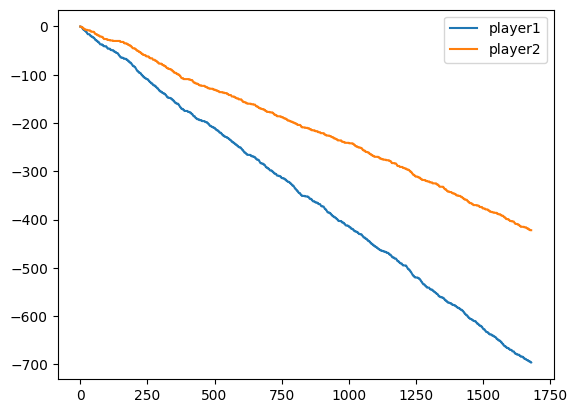

In [18]:
result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [19]:
model_save_path1 = os.path.join("log", "hommul", "dqn", "policy1.pth")
model_save_path2 = os.path.join("log", "hommul", "dqn", "policy2.pth")
if not hasattr(policy.policies[agents[0]], 'nolearn'):
    policy.policies[agents[0]].load_state_dict(torch.load(model_save_path1))
if not hasattr(policy.policies[agents[1]], 'nolearn'):
    policy.policies[agents[1]].load_state_dict(torch.load(model_save_path2))

death rate of player2: 0.249
ratio of death rate of player2 with respect to player1: 0.595


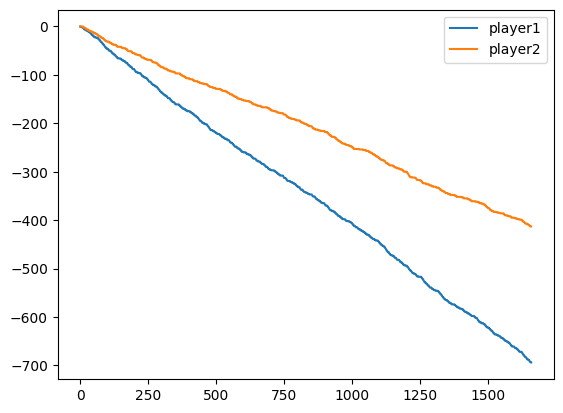

In [20]:
result = test_collector.collect(n_step=5000)
arr = result["rews"]
death_rates = np.sum(arr, axis=0) / np.sum(arr, axis=0)[0]
print(f"death rate of player2: {(np.sum(arr, axis=0) / arr.shape[0])[-1] * -1:.3f}")
print(f"ratio of death rate of player2 with respect to player1: {death_rates[-1]:.3f}")
plt.plot(arr.cumsum(axis=0))
plt.legend(("player1", "player2"))
plt.show()

In [21]:
df = []
obs = []

for days_left in range(1, 3):
    for player1_life_points in range(4):
        for player2_life_points in range(4):
            for payoff in [0.2, 0.4]:
                for player1_action in range(0, 3):
                    for player2_action in range(0, 3):
                        curr_obs = [
                            days_left, 
                            player1_life_points, 
                            player2_life_points, 
                            payoff,
                            payoff,
                            player1_action, 
                            player2_action
                        ]
                        obs.append({
                            'agent_id': 'player2',
                            'obs': np.array([curr_obs], dtype='float32'),
                            'mask': [True, True, False]
                        })
                        df.append(curr_obs)

cols = [
    "days_left", 
    "player1_life_points", 
    "player2_life_points", 
    "player1_prob_payoff",
    "player2_prob_payoff",
    "player1_previous_action", 
    "player2_previous_action"
]
df = pd.DataFrame(df, columns=cols)

df["player2_predicted_action"] = policy.policies[agents[1]](Batch(obs=obs, info={})).act
df["player2_logit_wait"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 0]
df["player2_logit_play"] = policy.policies[agents[1]](Batch(obs=obs, info={})).logits.detach().cpu().numpy()[:, 1]

df["player1_previous_action"] = df["player1_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_previous_action"] = df["player2_previous_action"].map({0: "wait", 1: "play", 2: "none"})
df["player2_predicted_action"] = df["player2_predicted_action"].map({0: "wait", 1: "play"})

df.to_csv("outcome_table.csv", index=False)

df.head()

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
0,1,0,0,0.2,0.2,wait,wait,wait,-4.772681,-5.132059
1,1,0,0,0.2,0.2,wait,play,wait,-5.245391,-5.901261
2,1,0,0,0.2,0.2,wait,none,wait,-5.887375,-6.596521
3,1,0,0,0.2,0.2,play,wait,play,-5.147863,-4.952644
4,1,0,0,0.2,0.2,play,play,play,-5.131122,-4.994402


In [22]:
(df["player2_predicted_action"] == "play").mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.4895833333333333

In [23]:
df[df["player2_predicted_action"] == "play"].tail(15)

,days_left,player1_life_points,player2_life_points,player1_prob_payoff,player2_prob_payoff,player1_previous_action,player2_previous_action,player2_predicted_action,player2_logit_wait,player2_logit_play
549,2,3,2,0.4,0.4,wait,wait,play,-3.259136,-2.688664
550,2,3,2,0.4,0.4,wait,play,play,-3.234160,-3.150015
552,2,3,2,0.4,0.4,play,wait,play,-3.007194,-2.206390
553,2,3,2,0.4,0.4,play,play,play,-2.762999,-2.281574
554,2,3,2,0.4,0.4,play,none,play,-2.700697,-2.331025
555,2,3,2,0.4,0.4,none,wait,play,-3.313978,-2.104050
556,2,3,2,0.4,0.4,none,play,play,-2.785404,-2.009682
557,2,3,2,0.4,0.4,none,none,play,-2.613736,-1.944121
564,2,3,3,0.2,0.2,none,wait,play,-2.577781,-2.327942
567,2,3,3,0.4,0.4,wait,wait,play,-2.287101,-2.022887
